In [ ]:
EXPERIMENT_ID = "epidemic"

In [2]:
%load_ext autoreload
%autoreload 2

import pathlib

import matplotlib.pyplot as plt
import matplotlib

import pandas as pd
pd.set_option('display.max_rows', None)

import numpy as np

from typing import List, Dict

plt.rcParams["font.size"] = "15"
matplotlib.rc('figure', figsize=[6,4])

from data_handlers.runtimes import *
from data_handlers.preprocessors import node_types

In [3]:
experiment_path = pathlib.Path(f"/research_data/{EXPERIMENT_ID}")

In [16]:
event_frame: pd.DataFrame
#event_frame = parse_bundle_events(experiment_path)
event_frame = pd.read_csv("/research_data/cadr.csv", dtype={"routing": str, "sim_instance_id": int, "event": str, "node": str, "from_to": str, "bundle": str}, parse_dates=["timestamp"])

In [5]:
groups = event_frame.groupby("bundle")
#groups.apply(lambda x: print(x[x["bundle"] == "dtn://n29/-648560019-0"]))

In [6]:
bundles: List[str]
successful: List[str]
unsuccessful: List[str]
runtimes_df: pd.DataFrame

bundles, successful, unsuccessful, runtimes_df = compute_bundle_runtimes(event_frame=event_frame)

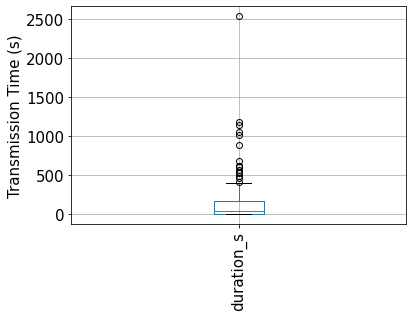

In [7]:
for routing, routing_df in list(runtimes_df.groupby(['routing'])):
    
    plot = routing_df.boxplot(
        column='duration_s', 
        #by=['Size (MiB)'],
        rot=90,
        #positions=[
        #    0, 1, 2, 3,
        #    5, 6, 7, 8,
        #    10, 11, 12, 13,
        #    15, 16, 17, 18,
        #    20, 21, 22, 23,
        #    25, 26, 27, 28
        #]
    )
    
    plt.title("")
    plt.suptitle("")
    
    #plt.xlabel("")
    #plot.set_xticklabels(["DTN7", "Forban", "IBR-DTN", "Serval"]*6, minor=False)

    plt.ylabel("Transmission Time (s)")
    #plt.yscale('log')
    #plot.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #plot.yaxis.set_label_coords(-0.15, 0.5)
    
    #plot.annotate('64 KiB', (0,0), (8, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    #plot.annotate('1 MiB', (0,0), (68, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    #plot.annotate('5 MiB', (0,0), (129, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    #plot.annotate('25 MiB', (0,0), (186, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    #plot.annotate('50 MiB', (0,0), (246, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    #plot.annotate('100 MiB', (0,0), (301, -60), xycoords='axes fraction', textcoords='offset points', va='top')
    
    #plt.savefig("plots/chain-runtimes-{}.pdf".format(node_num), bbox_inches='tight')
plt.show()

In [8]:
types: Dict[str, str] = node_types(scenario_path="/home/msommer/devel/cadr-evaluation/scenarios/wanderwege/wanderwege.xml")
touched_nodes: Dict[str, List[str]] = {}
touched_node_types: Dict[str, List[str]] = {}
number_of_nodes: Dict[str, int] = {}

for bundle in bundles:
    bundle_nodes = event_frame[event_frame.bundle == bundle].node.unique().tolist()
    touched_nodes[bundle] = bundle_nodes
    number_of_nodes[bundle] = len(bundle_nodes)
    bundle_node_types = set()
    for node in bundle_nodes:
        bundle_node_types.add(types[node])
    touched_node_types[bundle] = list(bundle_node_types)

Node n12 is a backbone
Node n13 is a backbone
Node n14 is a backbone
Node n15 is a backbone
Node n16 is a backbone
Node n17 is a sensor
Node n18 is a sensor
Node n19 is a sensor
Node n20 is a sensor
Node n21 is a sensor
Node n22 is a sensor
Node n23 is a sensor
Node n24 is a sensor
Node n25 is a sensor
Node n26 is a sensor
Node n27 is a sensor
Node n28 is a sensor
Node n29 is a sensor
Node n30 is a sensor
Node n31 is a sensor
Node n32 is a sensor
Node n33 is a sensor
Node n34 is a sensor
Node n35 is a sensor
Node n36 is a sensor
Node n37 is a sensor
Node n38 is a sensor
Node n39 is a sensor
Node n40 is a sensor
Node n41 is a sensor
Node n42 is a sensor
Node n43 is a sensor
Node n44 is a sensor
Node n45 is a sensor
Node n46 is a sensor
Node n47 is a sensor
Node n48 is a sensor
Node n49 is a sensor
Node n50 is a sensor
Node n51 is a sensor
Node n2 is a visitor
Node n3 is a visitor
Node n4 is a visitor
Node n5 is a visitor
Node n6 is a visitor
Node n7 is a visitor
Node n8 is a visitor
Nod

In [9]:
def bundle_distribution(instance_data: pd.DataFrame) -> None:
    bundle_creations: pd.DataFrame = instance_data[instance_data.event == "creation"]
    total_bundles: int = len(bundle_creations)
    print(f"Total bundles: {total_bundles}")

    simulation_start: np.datetime64 = instance_data[instance_data.event == "start"]["timestamp"].iloc[0]
    print(f"Simulation Start: {simulation_start}")
    simulation_end: np.datetime64 = simulation_start + np.timedelta64(1, "h")
    print(f"Simulation End: {simulation_end}")

    time_increments = np.timedelta64(60, 's')

    nodes_data = instance_data.groupby("node")

    nodes_bundles: Dict[str, List[int]] = {}

    for node, data in nodes_data:
        node_bundles: List[int] = bundles_per_node(node_data=data, simulation_start=simulation_start, simulation_end=simulation_end, time_increments=time_increments)
        nodes_bundles[node] = node_bundles

    print(nodes_bundles)

def bundles_per_node(node_data: pd.DataFrame, simulation_start: np.datetime64, simulation_end: np.datetime64, time_increments: np.timedelta64 = 60) -> List[int]:
    t_low: np.datetime64 = simulation_start
    t_high: np.datetime64 = t_low + time_increments
    bundles = 0
    bundle_time_series: List[int] = []

    receive_events = node_data[node_data.event == "reception"]

    while t_high <= simulation_end:
        in_time_window = receive_events[(t_low < receive_events.timestamp) & (receive_events.timestamp <= t_high)]
        receptions_during_interval = len(in_time_window)
        bundles += receptions_during_interval
        bundle_time_series.append(bundles)

        t_low = t_high
        t_high += time_increments

    return bundle_time_series

In [10]:
#event_frame.groupby("sim_instance_id").apply(bundle_distribution)

In [19]:
time_frame = event_frame.set_index("timestamp")

In [ ]:
len(time_frame[time_frame.sim_instance_id == 2])